# Chunking and SQLite

In this notebook, we'll see a couple of techniques that can be used when working with large file in Python.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm.notebook import tqdm

In [4]:
db = sqlite3.connect('nppes.sqlite')

Before we do anything else, let's see how many rows are contained in the Calls for Service file. 

In [ ]:
#using terminal  "wc -l file.txt"

In [ ]:
npi_cols=['NPI',
 'Entity Type Code',
 'Replacement NPI',
 'Employer Identification Number (EIN)',
 'Provider Organization Name (Legal Business Name)',
 'Provider Last Name (Legal Name)',
 'Provider First Name',
 'Provider Credential Text',
 'Provider First Line Business Practice Location Address',
 'Provider Second Line Business Practice Location Address',
 'Provider Business Practice Location Address City Name',
 'Provider Business Practice Location Address State Name',
 'Provider Business Practice Location Address Postal Code',
 'Provider Gender Code',
 'Healthcare Provider Taxonomy Code_1',
 'Healthcare Provider Primary Taxonomy Switch_1',
 'Healthcare Provider Taxonomy Code_2',
 'Healthcare Provider Primary Taxonomy Switch_2',
 'Healthcare Provider Taxonomy Code_3',
 'Healthcare Provider Primary Taxonomy Switch_3',
 'Healthcare Provider Taxonomy Code_4',
 'Healthcare Provider Primary Taxonomy Switch_4',
 'Healthcare Provider Taxonomy Code_5',
 'Healthcare Provider Primary Taxonomy Switch_5',
 'Healthcare Provider Taxonomy Code_6',
 'Healthcare Provider Primary Taxonomy Switch_6',
 'Healthcare Provider Taxonomy Code_7',
 'Healthcare Provider Primary Taxonomy Switch_7',
 'Healthcare Provider Taxonomy Code_8',
 'Healthcare Provider Primary Taxonomy Switch_8',
 'Healthcare Provider Taxonomy Code_9',
 'Healthcare Provider Primary Taxonomy Switch_9',
 'Healthcare Provider Taxonomy Code_10',
 'Healthcare Provider Primary Taxonomy Switch_10',
 'Healthcare Provider Taxonomy Code_11',
 'Healthcare Provider Primary Taxonomy Switch_11',
 'Healthcare Provider Taxonomy Code_12',
 'Healthcare Provider Primary Taxonomy Switch_12',
 'Healthcare Provider Taxonomy Code_13',
 'Healthcare Provider Primary Taxonomy Switch_13',
 'Healthcare Provider Taxonomy Code_14',
 'Healthcare Provider Primary Taxonomy Switch_14',
 'Healthcare Provider Taxonomy Code_15',
 'Healthcare Provider Primary Taxonomy Switch_15']

First, we need to connect to our database. The connect function will either create a new database if one does not already exist or connect to an existing one.

Now, we can chunk through the data and for each row, add the rows to a table in our sqlite database. 
To keep track of how much progress has been made, we can use the `tqdm` library.

In [ ]:
#create a function to loop through taxonomy of providers code
def find_primary_code(row):
    for i in range(1,16):
        if row[f'healthcare_provider_primary_taxonomy_switch_{i}']=='Y':
            return row[f'healthcare_provider_taxonomy_code_{i}']
#chunking in
for chunk in tqdm(pd.read_csv('NPPES_Data_Dissemination_February_2021/npidata_pfile_20050523-20210207.csv', usecols=npi_cols, chunksize = 10000)):
    chunk.columns = [x.lower().replace(' ', '_').replace('(', '').replace(')','').replace('*','') for x in chunk.columns]      # Clean up the column names
    chunk['taxonomy']= chunk.apply(lambda row: find_primary_code(row), axis=1)  #use the function above to create taxonomy column
    chunk=chunk[chunk.columns.drop(list(chunk.filter(regex='healthcare_provider_')))] #drop providers taxonomy code colums not needed anymore
    chunk.to_sql('npi_data', db, if_exists = 'append', index = False)


In [ ]:
db.close()

In [ ]:
#pull the npi_data back to pandas and make data frame

db = sqlite3.connect('nppes.sqlite')
query='''
select *
from npi_data
order by npi;
'''
npi_data = pd.read_sql(query, db)
npi_data

In [ ]:
db.close()

In [ ]:
npi_data.duplicated(subset=['npi']).value_counts() #check for duplicates in npi incase chunking and appending created duplicate

In [ ]:
npi_data=npi_data.drop_duplicates(subset=['npi'])

In [ ]:
#add the nucc_taxtable to nppes database 
db = sqlite3.connect('nppes.sqlite')
nucc_tax=pd.read_csv('NPPES_Data_Dissemination_February_2021/nucc_taxonomy_210.csv')
nucc_tax.columns = [x.lower().replace(' ', '_') for x in nucc_tax.columns]
nucc_tax.to_sql('nucc_tax', db,  if_exists='append', index = False)    


In [ ]:
#pull the nucc_tax back to pandas and make data frame
query='''
select *
from nucc_tax;
'''
nucc_tax = pd.read_sql(query, db)
nucc_tax

In [ ]:
db.close()

In [ ]:
nucc_tax.info()

To speed up queries which use a specific column, we can create an **index** on that column. This causes the database to store that column in a way that helps it to retrieve rows quicker.

In [ ]:
#db = sqlite3.connect('nppes.sqlite')
#db.execute('CREATE INDEX taxonomy ON npi_data(taxonomy)')
#db.execute('CREATE INDEX code ON nucc_tax(code)')

In [ ]:
#add the cbsa table to nppes database 

db = sqlite3.connect('nppes.sqlite')
cbsa=pd.read_csv('NPPES_Data_Dissemination_February_2021/ZIP_CBSA_122020.csv')
cbsa.columns = [x.lower().replace(' ', '_') for x in cbsa.columns]
cbsa.to_sql('cbsa', db,  if_exists='append', index = False)

In [ ]:
#pull the cbsa back to pandas and make data frame
db = sqlite3.connect('nppes.sqlite')
query= '''
select *       
from cbsa 
'''
cbsa = pd.read_sql(query, db)
cbsa

In [ ]:
#db = sqlite3.connect('nppes.sqlite')
#query= '''
#select *      
#from npi_data as np
#left join nucc_tax as nu
#on np.taxonomy=nu.code 
#join cbsa as c
#on np.provider_business_practice_location_address_postal_code=c.zip '''
#npp_nucc_tax = pd.read_sql(query, db)
#npp_nucc_tax

In [ ]:
cbsa.info()

In [ ]:
#left merge npi_data frame to nucc_tax (lefet merge to preserve all data on npi_data) These cal also be achived by hashed sqlite code abo

npp_nucc=pd.merge(npi_data, nucc_tax,left_on='taxonomy', right_on='code', how='left')

In [ ]:
df.duplicated(subset=['npi'], ).value_counts()

In [ ]:
npp_nucc.duplicated(subset=['npi']).value_counts()

In [ ]:
npp_nucc.head(50)


In [ ]:
#the postal_code and zip have diffrent length digits and data type. convert to string and get the first five digits

npp_nucc['postal_code']=npp_nucc['provider_business_practice_location_address_postal_code'].astype(str).str[0:5]

cbsa['zip1']=cbsa['zip'].astype(str).str[0:5]


In [ ]:
#merge cbsa data frame to npi_data + nucc_tax data from previous merge
npp_nucc_cbsa=pd.merge(npp_nucc, cbsa,left_on= 'postal_code', right_on='zip1', how='left')

In [ ]:
npp_nucc_cbsa.duplicated(subset=['npi']).value_counts()

In [ ]:
#drop duplicates due to zip matching multiple cbsa based on tot_ratio column
npp_nucc_cbsa=npp_nucc_cbsa.sort_values(by=['npi','tot_ratio']).drop_duplicates('npi', keep='last')

In [ ]:
#subset only to nashville area cbsa
npp_nucc_cbsa_nash=npp_nucc_cbsa[npp_nucc_cbsa['cbsa']==34980]


In [ ]:
#save the nashville area cbsa filse to csv (it has 38414 rows × 36 columns)
npp_nucc_cbsa_nash.to_csv('npp_taxo_cbsa_nash.csv',index=False)

In [ ]:
npp_nucc_cbsa[['npi','specialization','zip']].head(50)

In [ ]:
#add hop table to nppes database while also subseting on transaction and avarage wait days

db = sqlite3.connect('nppes.sqlite')
for chunk in tqdm(pd.read_csv('DocGraph_Hop_Teaming_2017_Non_Commercial/DocGraph_Hop_Teaming_2017.csv', chunksize = 100000)):
    chunk=chunk[(chunk['transaction_count']>=50) | (chunk['average_day_wait']<=50)]
    chunk.to_sql('hop', db, if_exists ='append', index = False)


In [4]:
#pull the hop table using pandas to data frame

db = sqlite3.connect('nppes.sqlite')
query='''
select *
from hop;
'''
hop_team = pd.read_sql(query, db)
hop_team 

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1033142146,1000000004,491,535,10.232,36.558
1,1013952357,1000000004,20,20,21.100,66.988
2,1013977990,1003000126,134,145,27.352,51.137
3,1023008182,1003000126,13,14,21.643,58.885
4,1013996669,1003000126,91,92,35.152,68.009
...,...,...,...,...,...,...
165242551,1235159252,1255367132,11,11,32.182,47.657
165242552,1235291360,1255367132,12,13,44.769,96.969
165242553,1235180266,1255367132,23,23,13.739,21.020
165242554,1265448617,1255367132,15,16,10.938,25.702


In [ ]:
db.close()

# Here I was thinking about edge wise column, so I concatnated (vertical) the two merges above. something to explore later. I shift to horizontal merging.

In [5]:
npp_nucc_cbsa_nash=pd.read_csv('npp_taxo_cbsa_nash.csv') 


In [6]:

#This is memory expensive method. so, I am hashing it
#npp_nucc_cbsa_nash_hop=pd.merge(npp_nucc_cbsa_nash, hop_team, left_on= 'npi', right_on='from_npi', how='inner')

In [4]:
#npp_nucc_cbsa_nash_hop.columns.tolist()

In [7]:
#npp_nucc_cbsa_nash_hop_from=npp_nucc_cbsa_nash_hop.drop(
    #columns=[
        'replacement_npi',
        'employer_identification_number_ein',
        'provider_name_prefix_text',
        'provider_name_suffix_text',
        'provider_first_line_business_practice_location_address',
        'provider_second_line_business_practice_location_address',
        'provider_business_practice_location_address_state_name',
        'provider_gender_code',
        'taxonomy',
        'code',
        'effective_date',
        'deactivation_date',
        'last_modified_date',
        'notes',
        'display_name',
        'zip',
        'cbsa',
        'res_ratio',
        'bus_ratio',
        'oth_ratio',
        'tot_ratio',
        'zip1'])

In [ ]:
#npp_nucc_cbsa_nash_hop_from_to=pd.merge(npp_nucc_cbsa_nash_hop_from, hop_team, left_on= 'npi', right_on='to_npi', how='inner')

In [ ]:
#npp_nucc_cbsa_nash_hop_horiz=pd.merge(npp_nucc_cbsa_nash_hop, hop_team, left_on= 'npi', right_on='to_npi', how='inner')

In [ ]:
#npp_nucc_cbsa_nash_hop_from_to.info()

In [ ]:
#npp_nucc_cbsa_nash_hop=npp_nucc_cbsa_nash_hop[npp_nucc_cbsa_nash_hop['entity_type_code']==1]

In [ ]:
#npp_nucc_cbsa_nash_hop.to_csv('npp_nucc_cbsa_nash_hop_from.csv',index=False)

In [ ]:
#npp_nucc_cbsa_nash_hop1=npp_nucc_cbsa_nash_hop1[npp_nucc_cbsa_nash_hop1['entity_type_code']==2]

In [ ]:
#npp_nucc_cbsa_nash_hop1.to_csv('npp_nucc_cbsa_nash_hop_to.csv',index=False)

In [ ]:
#npp_hop_dfs=[npp_nucc_cbsa_nash_hop,npp_nucc_cbsa_nash_hop1]

In [ ]:
#npp_nucc_cbsa_nash_hop_all=pd.concat(npp_hop_dfs, keys=['from', 'to'])

In [ ]:
#npp_nucc_cbsa_nash_hop_all.to_csv('npp_nucc_cbsa_nash_hopall.csv',index=False)

In [ ]:
#npp_nucc_cbsa_nash_hop_all.info()

In [ ]:
#back to sqlite for merging nashville_npi and hope_team data horizontally

In [ ]:
#add nashville npp_taxo_cbsa_nash to nppes database as table
db = sqlite3.connect('nppes.sqlite')
for chunk in tqdm(pd.read_csv('npp_taxo_cbsa_nash.csv', chunksize = 10000)):
    chunk.to_sql('nash_npp', db, if_exists ='append', index = False)

In [ ]:
#create index on npi in each table for merging speeed

db = sqlite3.connect('nppes.sqlite')
db.execute('CREATE INDEX npi ON nash_npp(npi)')
db.execute('CREATE INDEX npif ON hop(from_npi)')
db.execute('CREATE INDEX npit ON hop(to_npi)')

In [ ]:
db.close()

In [3]:
db = sqlite3.connect('nppes.sqlite')
query= '''
select 
nnp_from.entity_type_code,
nnp_from.employer_identification_number_ein,
nnp_from.provider_organization_name_legal_business_name,
nnp_from.provider_last_name_legal_name,
nnp_from.provider_first_name,
nnp_from.provider_business_practice_location_address_city_name,
nnp_from.provider_gender_code,
nnp_from.grouping,
nnp_from.classification,
nnp_from.specialization, 
nnp_to.entity_type_code as entity_type_code_to,
nnp_to.employer_identification_number_ein as employer_identification_number_ein_to,
nnp_to.provider_organization_name_legal_business_name as provider_organization_name_legal_business_name_to,
nnp_to.provider_last_name_legal_name as provider_last_name_legal_name_to,
nnp_to.provider_first_name as provider_first_name_to,
nnp_to.provider_business_practice_location_address_city_name as provider_business_practice_location_address_city_name_to,
nnp_to.provider_gender_code as provider_gender_code_to,
nnp_to.grouping as grouping_to,
nnp_to.classification as classification_to,
nnp_to.specialization as specialization_to,
from_npi,to_npi, patient_count, transaction_count, average_day_wait, std_day_wait

from hop as hp
inner join nash_npp as nnp_from
on hp.from_npi=nnp_from.npi
inner join nash_npp as nnp_to
on nnp_to.npi=hp.to_npi
where nnp_from.entity_type_code=1 and nnp_to.entity_type_code=2
'''
nash_npp_hop_fromto = pd.read_sql(query, db)
nash_npp_hop_fromto


,entity_type_code,employer_identification_number_ein,provider_organization_name_legal_business_name,provider_last_name_legal_name,provider_first_name,provider_business_practice_location_address_city_name,provider_gender_code,grouping,classification,specialization,...,provider_gender_code_to,grouping_to,classification_to,specialization_to,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1.0,None,None,REZK,HANY,COLUMBIA,M,Allopathic & Osteopathic Physicians,Internal Medicine,Nephrology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1033297429,1003028770,56,62,53.145,58.831
1,1.0,None,None,MAHONEY,ROBERT,NASHVILLE,M,Allopathic & Osteopathic Physicians,Radiology,Diagnostic Radiology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1043206329,1003028770,173,177,97.864,81.756
2,1.0,None,None,WIESMAN,H,COLUMBIA,M,Allopathic & Osteopathic Physicians,Orthopaedic Surgery,None,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1003922881,1003028770,17,21,45.619,41.519
3,1.0,None,None,HAYES,BENJAMIN,SPRING HILL,M,Allopathic & Osteopathic Physicians,Dermatology,Pediatric Dermatology,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1003963976,1003028770,2535,3945,0.000,0.000
4,1.0,None,None,WHITE,BOBBY,NASHVILLE,M,Allopathic & Osteopathic Physicians,Internal Medicine,None,...,None,Allopathic & Osteopathic Physicians,Dermatology,None,1073605499,1003028770,12,14,47.571,49.273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175792,1.0,None,None,SHARIFI,HAYDEH,SMYRNA,F,Allopathic & Osteopathic Physicians,Family Medicine,None,...,None,Other Service Providers,Specialist,None,1235102617,1992985055,55,119,0.000,0.000
175793,1.0,None,None,PATEL,PRAKASHCHANDRA,SMYRNA,M,Allopathic & Osteopathic Physicians,Internal Medicine,Pulmonary Disease,...,None,Other Service Providers,Specialist,None,1558384099,1992985055,23,39,28.333,39.600
175794,1.0,None,None,MANGIONE,NELSON,SMYRNA,M,Allopathic & Osteopathic Physicians,Internal Medicine,Cardiovascular Disease,...,None,Other Service Providers,Specialist,None,1164504544,1992985055,26,38,38.868,48.749
175795,1.0,None,None,HART,JAMES,FRANKLIN,M,Allopathic & Osteopathic Physicians,Psychiatry & Neurology,Psychiatry,...,None,Other Service Providers,Specialist,None,1215915871,1992985055,32,39,10.359,27.306


In [ ]:
#nash_npp_hop_fromto=nash_npp_hop_fromto[nash_npp_hop_fromto['transaction_count']>=50]

In [ ]:
#nash_npp_hop_fromto=nash_npp_hop_fromto[nash_npp_hop_fromto['average_day_wait']<=50]

In [5]:
nash_npp_hop_fromto.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['entity_type_code', 'employer_identification_number_ein',
       'provider_organization_name_legal_business_name',
       'provider_last_name_legal_name', 'provider_first_name',
       'provider_business_practice_location_address_city_name',
       'provider_gender_code', 'grouping', 'classification', 'specialization',
       'entity_type_code_to', 'employer_identification_number_ein_to',
       'provider_organization_name_legal_business_name_to',
       'provider_last_name_legal_name_to', 'provider_first_name_to',
       'provider_business_practice_location_address_city_name_to',
       'provider_gender_code_to', 'grouping_to', 'classification_to',
       'specialization_to', 'from_npi', 'to_npi', 'patient_count',
       'transaction_count', 'average_day_wait', 'std_day_wait'],
      dtype='object')>

In [6]:
#save the final csv file of nppes and hop_team data merged and ready for analysis (175797 rows × 26 columns)

nash_npp_hop_fromto.to_csv('nash_npp_hop_fromto.csv', index=False)

<AxesSubplot:ylabel='grouping_to'>

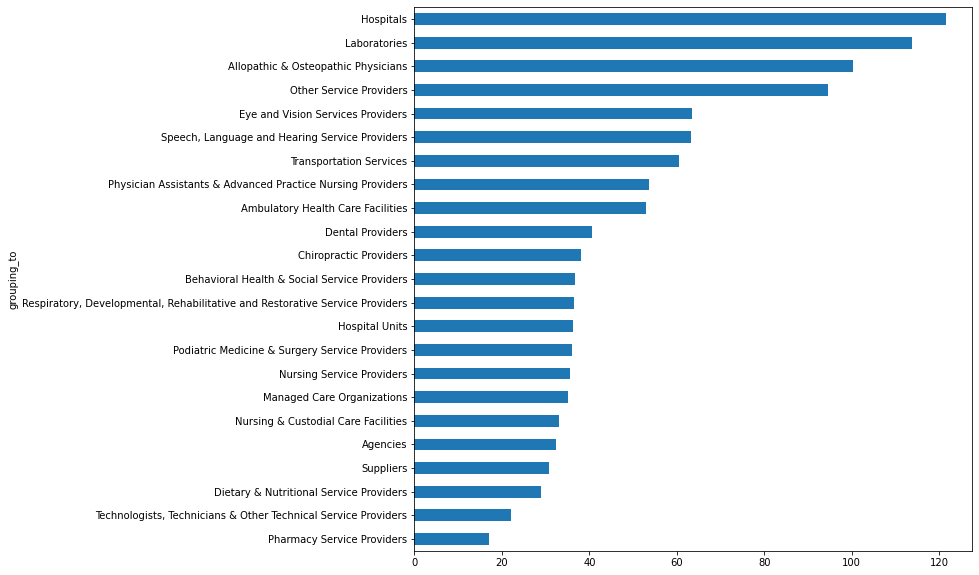

In [40]:
nash_npp_hop_fromto.groupby('grouping_to')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='grouping'>

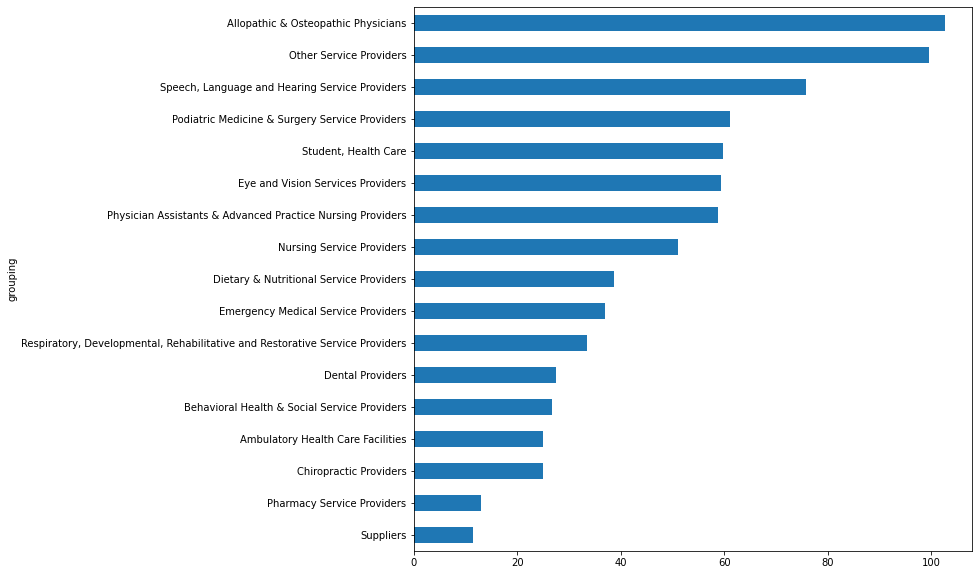

In [39]:
nash_npp_hop_fromto.groupby('grouping')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='classification_to'>

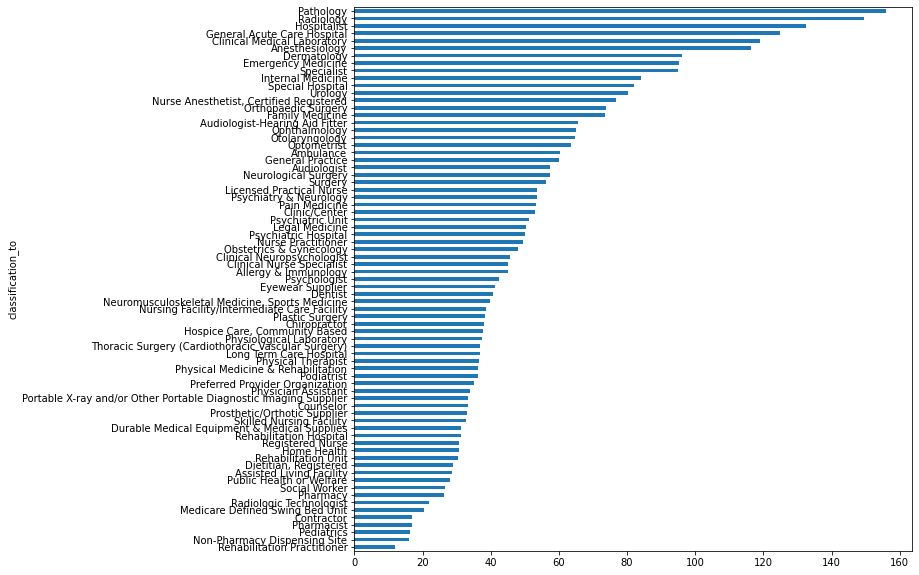

In [38]:
nash_npp_hop_fromto.groupby('classification_to')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='classification'>

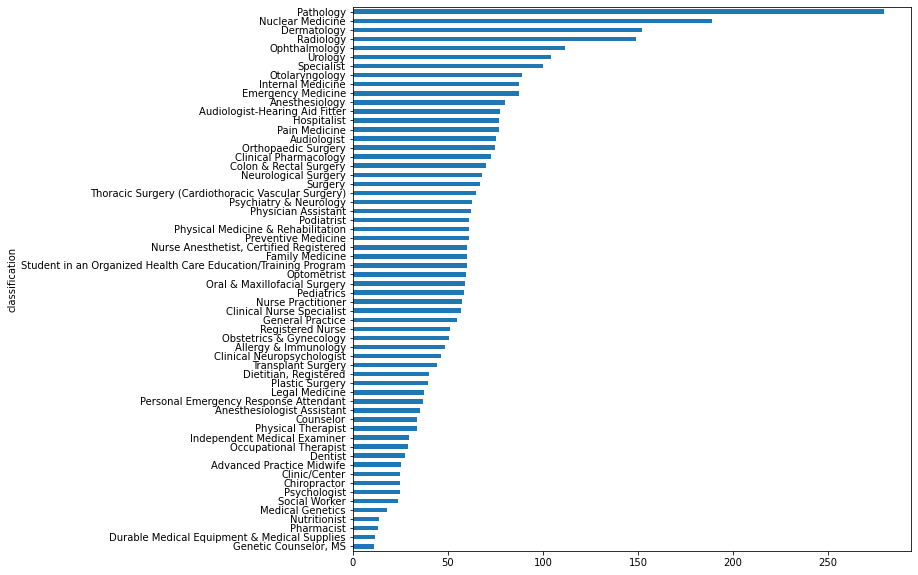

In [37]:
nash_npp_hop_fromto.groupby('classification')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,10))

<AxesSubplot:ylabel='specialization_to'>

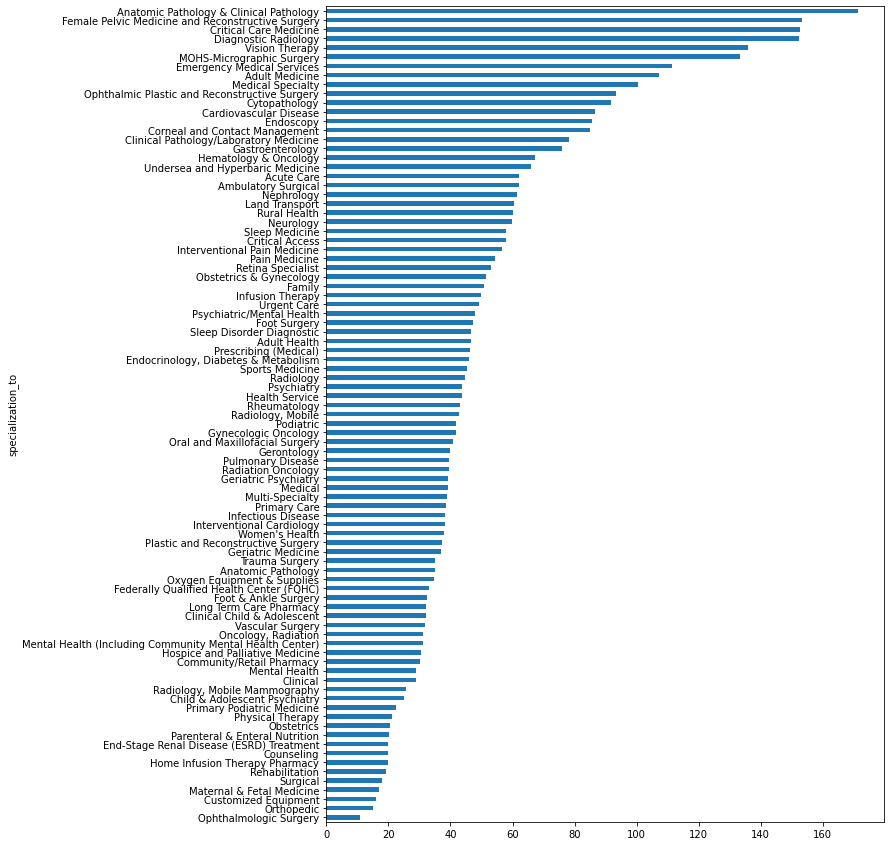

In [45]:
nash_npp_hop_fromto.groupby('specialization_to')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,15))

<AxesSubplot:ylabel='specialization'>

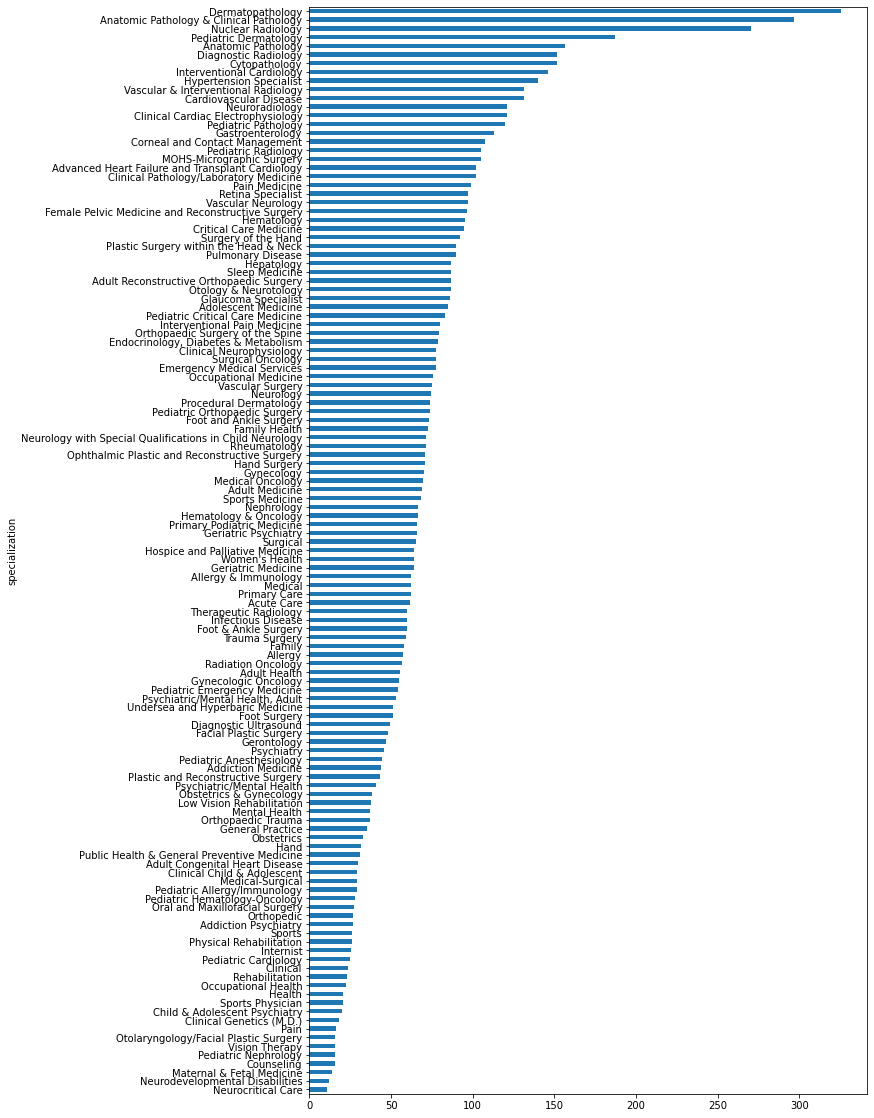

In [47]:
nash_npp_hop_fromto.groupby('specialization')['patient_count'].mean().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='classification'>

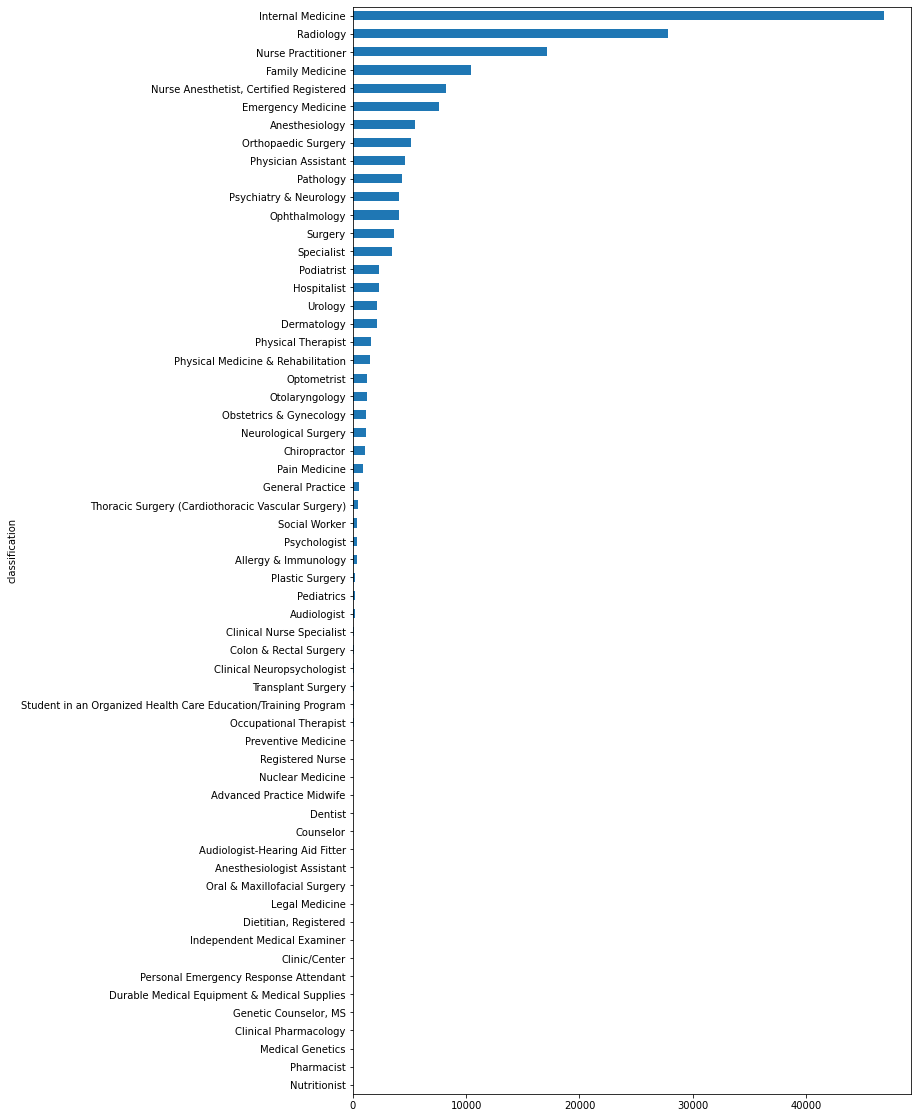

In [50]:
nash_npp_hop_fromto.groupby('classification')['to_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='specialization'>

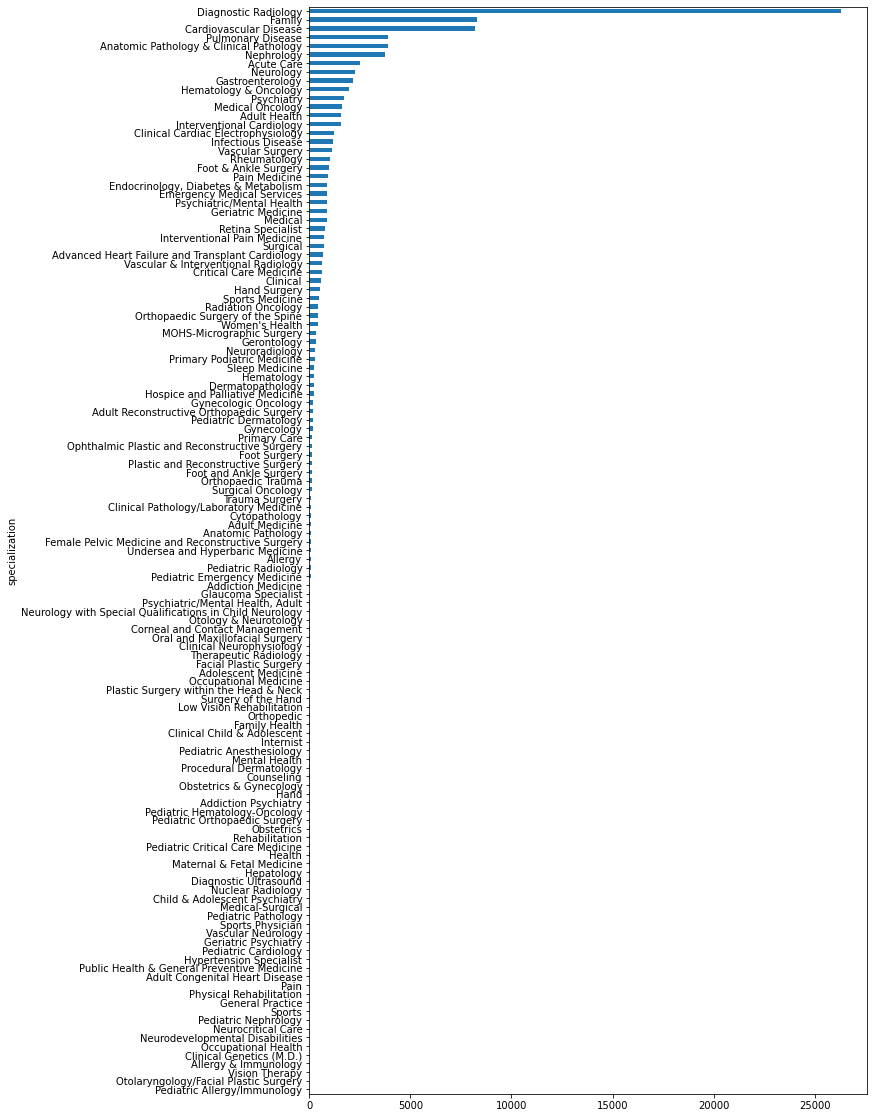

In [51]:
nash_npp_hop_fromto.groupby('specialization')['to_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='specialization_to'>

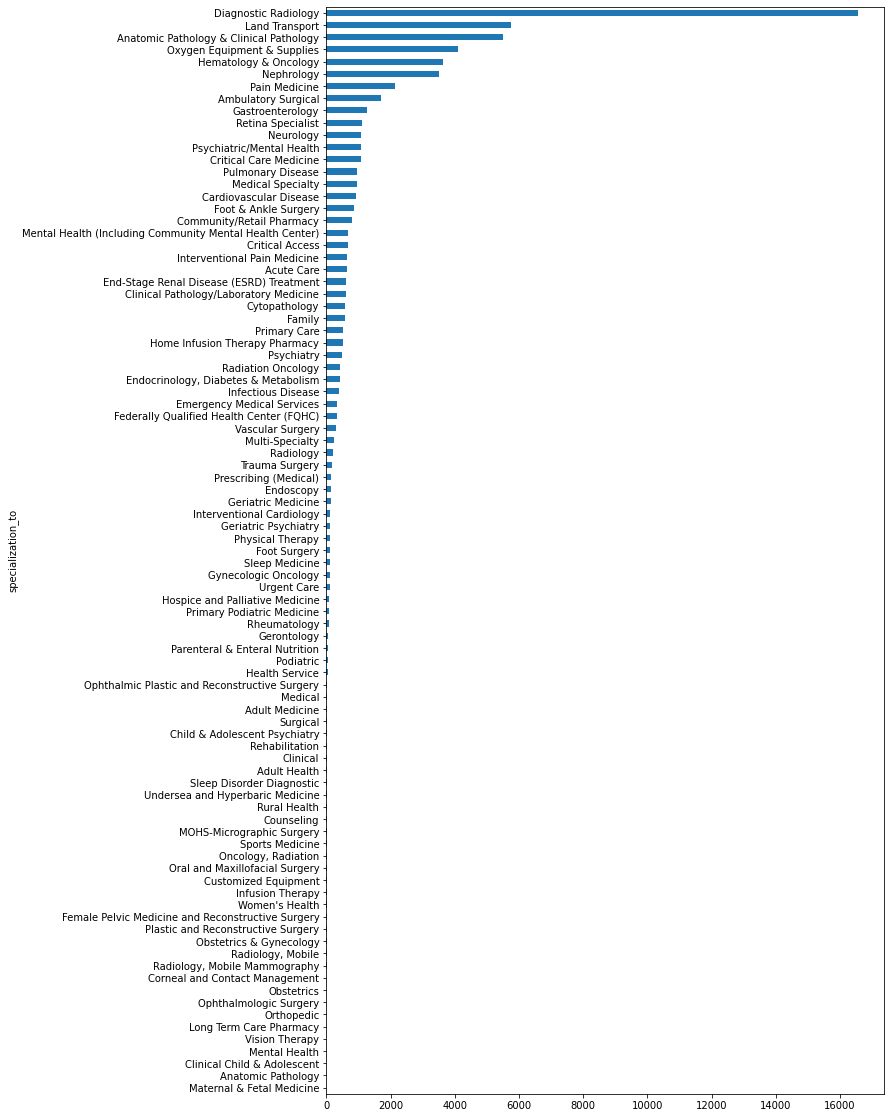

In [52]:
nash_npp_hop_fromto.groupby('specialization_to')['from_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

<AxesSubplot:ylabel='classification_to'>

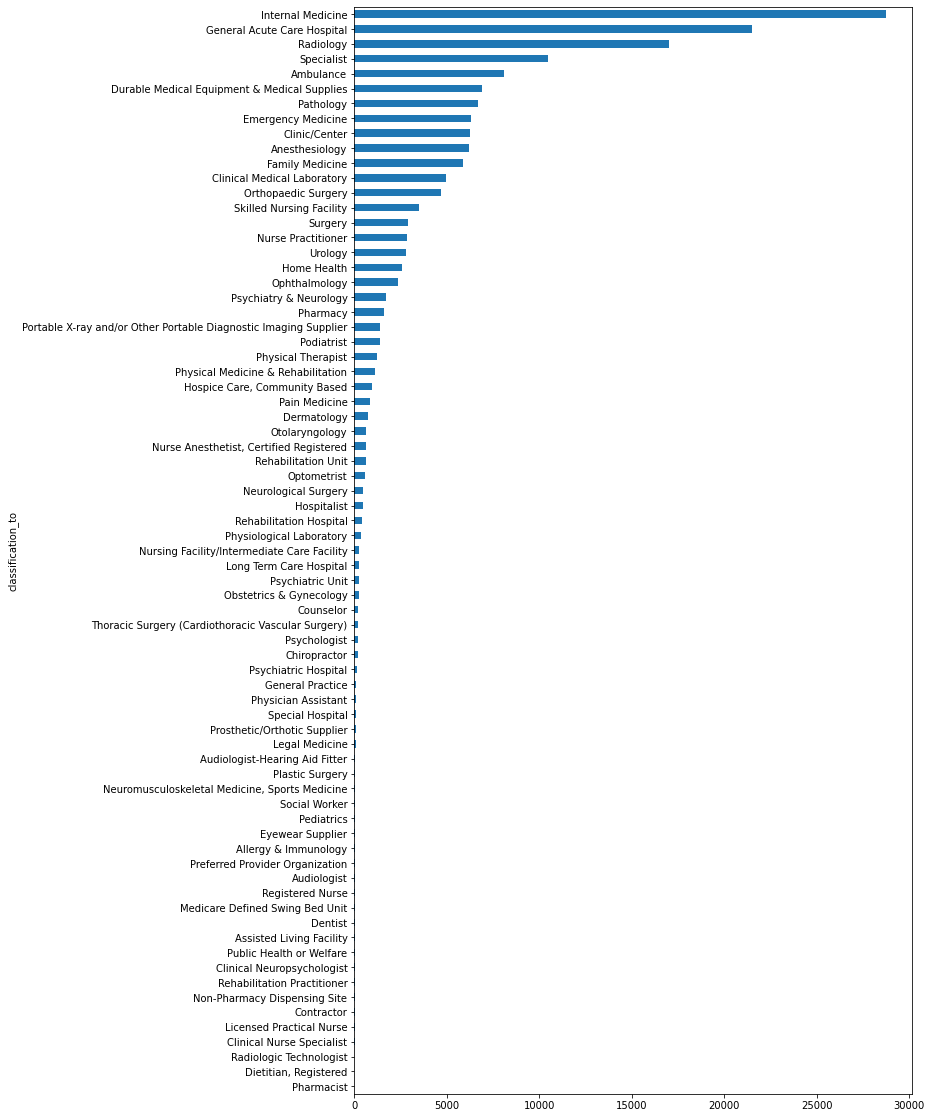

In [54]:
nash_npp_hop_fromto.groupby('classification_to')['from_npi'].count().sort_values(ascending=True).plot.barh(figsize=(10,20))

In [98]:
organ_ref_numb=nash_npp_hop_fromto.groupby(['provider_organization_name_legal_business_name_to'])['from_npi'].count().reset_index(name="count")

<AxesSubplot:ylabel='provider_organization_name_legal_business_name_to'>

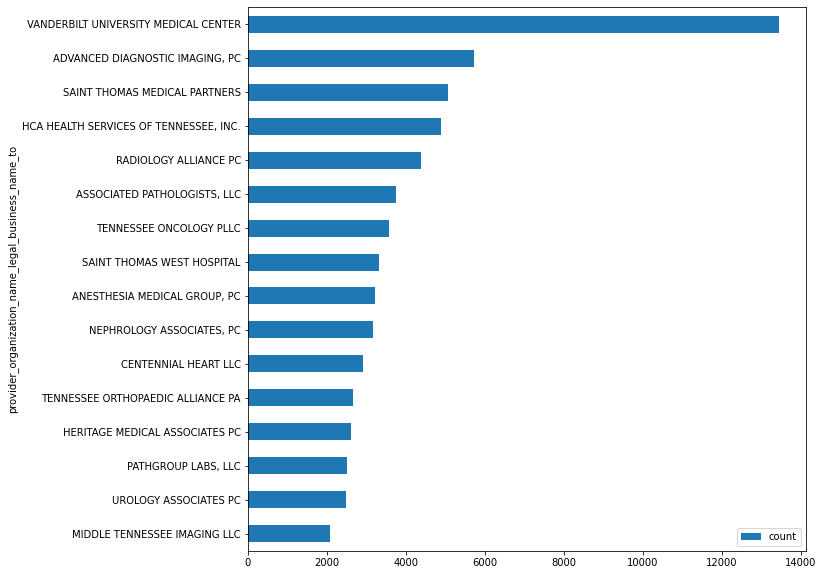

In [99]:
organ_ref_numb=organ_ref_numb[organ_ref_numb['count']>=2000]
organ_ref_numb.sort_values(by='count', ascending=True).plot.barh(x='provider_organization_name_legal_business_name_to', y='count', figsize=(10,10))

In [161]:
patient_count_referee=nash_npp_hop_fromto.groupby(
    ['provider_organization_name_legal_business_name_to', 'classification','provider_last_name_legal_name', 'provider_first_name'])[
    ['patient_count']].agg('sum').reset_index().sort_values(by=['provider_organization_name_legal_business_name_to', 'patient_count'], ascending=False)

patient_count_referee[(patient_count_referee['patient_count']>2000) & 
                      (patient_count_referee[
                          'classification']!='Radiology') &
                      ((~patient_count_referee[
                          'provider_organization_name_legal_business_name_to'].isin([
                          'VANDERBILT UNIVERSITY MEDICAL CENTER',
                          'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER'])))]
                    
                        
                        
                        
                       

,provider_organization_name_legal_business_name_to,classification,provider_last_name_legal_name,provider_first_name,patient_count
103693,UROLOGY ASSOCIATES PC,Pathology,WELCH,DEREK,10584
100345,THE SURGICAL CLINIC PLLC,Pathology,WELCH,DEREK,2192
98904,TENNESSEE RETINA PC,Ophthalmology,WALLACE,ROY,3676
98870,TENNESSEE RETINA PC,Ophthalmology,AWH,CARL,3172
98868,TENNESSEE RETINA PC,Ophthalmology,ARRINDELL,EVERTON,2940
...,...,...,...,...,...
2100,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,GIBSON,DAVID,2312
1945,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,CANONICO,ANGELO,2230
2464,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,PETERS,MARK,2218
1847,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,ALSOUB,MOHAMMAD,2082
